In [1]:
import torch

In [3]:
dataset = "CIFAR10" # ImageNet, MNIST, FashionMNIST, CIFAR10


# load data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# get RandAugment from torchvision
import torchvision
rand_augment =  None  #torchvision.transforms.RandAugment(num_ops=4, magnitude=9)


train_data, val_data, test_data = None, None, None
if dataset == "ImageNet":
    num_classes = 1000
    resolution = 224
    n_channels = 3
    transform = transforms.Compose([transforms.Resize(resolution), transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_transform = transforms.Compose([rand_augment, transforms.Resize(resolution), transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    dev_data = datasets.ImageNet(root="data", split="train", download=True, transform=transform)
    val_data = datasets.ImageNet(root="data", split="val", download=True, transform=transform)
    test_data = datasets.ImageNet(root="data", split="val", download=True, transform=transform)

elif dataset == "MNIST" or dataset == "FashionMNIST":
    num_classes = 10
    resolution = 28
    n_channels = 1
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
    train_transform = transforms.Compose([rand_augment, transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    if dataset == "MNIST":
        dev_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
        test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    else:
        dev_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

elif dataset == "CIFAR10":
    num_classes = 10
    resolution = 32
    n_channels = 3
    
    mean = [0.49139968, 0.48215827 ,0.44653124]
    std = [0.24703233, 0.24348505, 0.26158768]
    
    
    if rand_augment is None:
        # get augmentation for training to replicate MLTP paper
        rand_augment = transforms.Compose([transforms.RandomCrop(resolution, padding=4),# padding_mode="reflect"),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                            ])

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std),
                                    ])
    train_transform = transforms.Compose([rand_augment, 
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std),
                                         ])
                            
    dev_data = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
    test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# define conv net
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes, n_channels, resolution):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(n_channels, 32, 3, 1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1, padding=1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(resolution**2 // 4 * 64, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)        


    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output
    
   
# is CNet1 from https://arxiv.org/pdf/2002.12455.pdf
class CNet1(torch.nn.Module):
    def __init__(self, num_classes, n_channels, resolution):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(n_channels, 256, 3, 1, padding=1)
        self.fc1 = torch.nn.Linear(resolution**2 // 4 * 256, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)        

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

In [5]:
import torch

if val_data is None:
    # split dev data into train and validation
    train_size = int(0.8 * len(dev_data))
    val_size = len(dev_data) - train_size
    train_data, val_data = torch.utils.data.random_split(dev_data, [train_size, val_size])

# split train data into train and generalization
gen_size = int(0.8 * len(train_data))
train_size = len(train_data) - gen_size
train_data, gen_data = torch.utils.data.random_split(train_data, [train_size, gen_size])
# set train transform
train_data.dataset.transform = train_transform

In [6]:
resolution * resolution * 64 // 2

32768

In [7]:
# test conv net
model = ConvNet(num_classes, n_channels, resolution)
input_data = torch.randn(1, n_channels, resolution, resolution)
output = model(input_data)
print(output)
pred = output.argmax(dim=1, keepdim=True)
print(pred)

tensor([[-2.4260, -2.2189, -2.3545, -2.3785, -2.3691, -2.3122, -2.1839, -2.4374,
         -2.2254, -2.1660]], grad_fn=<LogSoftmaxBackward0>)
tensor([[9]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


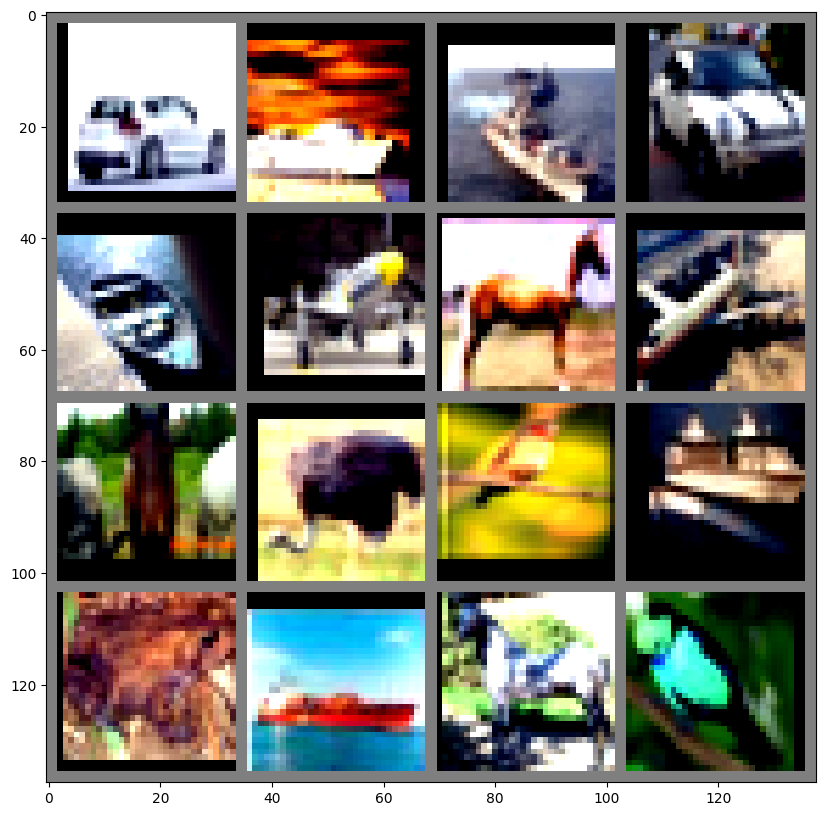

In [8]:
# test training augmentation by plotting some images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dl = torch.utils.data.DataLoader(dev_data, batch_size=16, shuffle=True, num_workers=0)
dataiter = iter(dl)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images, nrow=4))

In [9]:
images.shape

torch.Size([16, 3, 32, 32])

In [10]:
# train loss function
def calc_train_loss(model, data, target):
    output = model(data)
    loss = torch.nn.functional.nll_loss(output, target)
    return loss


import copy


# define train2generalize loss function
def train2generalize(model, data, target, gen_loader, optimizer, reset_net=False, **kwargs):
    # train for one step, then test on one generalization data batch and backprop

    # save current model parameters
    if reset_net:
        model_params = copy.deepcopy(model.state_dict())        

    # update weights
    loss = calc_train_loss(model, data, target)
    optimizer.zero_grad()
    loss.backward(create_graph=True)
    optimizer.step()

    # test on one generalization data batch
    gen_data, gen_target = next(iter(gen_loader))
    gen_data, gen_target = gen_data.to(device), gen_target.to(device)
    gen_loss = calc_train_loss(model, gen_data, gen_target)

    optimizer.zero_grad()

    if reset_net:
        # reset model parameters to only make use of second order information
        # restore model parameters by subtracting the difference between the current and saved parameters
        for param, saved_param in zip(model.parameters(), model_params.values()):
            param.data -= param.data - saved_param.detach()

    return gen_loss


def train2generalize2(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    #print(data.device, target.device, model.fc1.weight.device)
    loss_fast = calc_train_loss(model, data, target)
    grad = torch.autograd.grad(loss_fast, model.parameters(), create_graph=True)
    fast_weights = list(map(lambda p: p[1] - inner_lr * p[0], zip(grad, model.parameters())))

    # load fast weights into fast_net
    fast_net.load_state_dict(dict(zip(fast_net.state_dict().keys(), fast_weights)))
    # print grad of fast_net to check if it is the same as grad
    print("grad", grad[0][0,0,0,0])
    print("fast_net", fast_net.conv1.weight.grad[0,0,0,0])
    gen_data, gen_target = next(iter(gen_loader))
    gen_data, gen_target = gen_data.to(device), gen_target.to(device)

    loss_gen = calc_train_loss(fast_net, gen_data, gen_target)
    return loss_gen


def train2generalize_with_l2l(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    import learn2learn as l2l
    maml = l2l.algorithms.MAML(model, lr=inner_lr)
    for iteration in range(1):
        optimizer.zero_grad()
        task_model = maml.clone()  # torch.clone() for nn.Modules
        adaptation_loss = calc_train_loss(task_model, data, target)
        task_model.adapt(adaptation_loss)  # computes gradient, update task_model in-place

        gen_data, gen_target = next(iter(gen_loader))
        gen_data, gen_target = gen_data.to(device), gen_target.to(device)
        evaluation_loss = calc_train_loss(task_model, gen_data, gen_target)
    return evaluation_loss
   

def train2generalize_with_higher(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    import higher
    # When you want to branch from the current state of your model and unroll
    # optimization, follow this example. This context manager gets a snapshot of the
    # current version of the model and optimizer at the point where you want to
    # start unrolling and create a functional version `fmodel` which executes the
    # forward pass of `model` with implicit fast weights which can be read by doing
    # `fmodel.parameters()`, and a differentiable optimizer `diffopt` which ensures
    # that at each step, gradient of `fmodel.parameters()` with regard to initial
    # fast weights `fmodel.parameters(time=0)` (or any other part of the unrolled
    # model history) is defined.
    n_inner_iter = 1
    inner_opt = torch.optim.SGD(model.parameters(), lr=inner_lr)

    with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
        for _ in range(n_inner_iter):
            logits = fmodel(data)  # modified `params` can also be passed as a kwarg
            loss = torch.nn.functional.nll_loss(logits, target)
            # no need to call loss.backwards()
            diffopt.step(loss)  # note that `step` must take `loss` as an argument!
        # The final set of adapted parameters will induce some
        # final loss and accuracy on the query dataset.
        # These will be used to update the model's meta-parameters.


        # At this point, or at any point in the iteration, you can take the
        # gradient of `fmodel.parameters()` (or equivalently
        # `fmodel.fast_params`) w.r.t. `fmodel.parameters(time=0)` (equivalently
        # `fmodel.init_fast_params`). i.e. `fast_params` will always have
        # `grad_fn` as an attribute, and be part of the gradient tape.

        # At the end of your inner loop you can obtain these e.g. ...
        #grad_of_grads = torch.autograd.grad(
        #    meta_loss_fn(fmodel.parameters()), fmodel.parameters(time=0))
        gen_data, gen_target = next(iter(gen_loader))
        gen_data, gen_target = gen_data.to(device), gen_target.to(device)
        eval_loss = calc_train_loss(fmodel, gen_data, gen_target)
    return eval_loss

import time
from torch.cuda.amp import GradScaler, autocast


# define train function
def train(model, device, train_loader, optimizer, scaler, epoch, use_train2generalize=False, gen_loader=None, train_to_generalize_kwargs=None, 
         save_graph=False):
    model.train()

    if use_train2generalize:
        fast_net = copy.deepcopy(model).to(device)

    start_time = time.time()
    
    train_losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        
        # Runs the forward pass with autocasting.
        with autocast():
            if use_train2generalize:
                if train_to_generalize_kwargs["use_l2l"] or train_to_generalize_kwargs["MLPT"]:
                    loss = train2generalize_with_l2l(model, data, target, gen_loader, optimizer, fast_net, **train_to_generalize_kwargs)
                elif train_to_generalize_kwargs["use_higher"]:
                    loss = train2generalize_with_higher(model, data, target, gen_loader, optimizer, fast_net, **train_to_generalize_kwargs)
                else:
                    loss = train2generalize(model, data, target, gen_loader, optimizer, **train_to_generalize_kwargs)
                    
                # for MLPT, add normal loss as well with scaling factor
                if train_to_generalize_kwargs["MLPT"]:
                    loss = loss * train_to_generalize_kwargs["MLPT"] + calc_train_loss(model, data, target) * (1 - train_to_generalize_kwargs["MLPT"])
            else:
                loss = calc_train_loss(model, data, target)

        if batch_idx == 0 and save_graph and 1 == 0:
            # visualize comp graph
            from torchviz import make_dot
            make_dot(loss).render("comp_graph", format="png")
            # print GPU memory usage with torch in GB
            print("GPU memory usage: ", torch.cuda.memory_allocated(device)/1e9, "GB")
            #print(torch.cuda.memory_summary(device=None, abbreviated=False))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
            
        train_losses.append(loss.detach())
        
        
    mean_train_loss = torch.mean(torch.tensor(train_losses)).item()
    print(f'Train Epoch: {epoch}  ({100. * batch_idx / len(train_loader):.0f}%) \t Loss: {mean_train_loss:.2f}', 
          f"Time: {time.time() - start_time:.2f}s")
    
    return mean_train_loss

# define test function
@torch.inference_mode()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)')
    return test_loss

In [11]:
torch.nn.Parameter(torch.tensor([0.001], requires_grad=True))

Parameter containing:
tensor([0.0010], requires_grad=True)

Number of parameters:  33567242
Average loss: 2.3090, Accuracy: 1056/10000 (10.56%)
Train Epoch: 1  (98%) 	 Loss: 5.69 Time: 5.53s
Average loss: 1.8325, Accuracy: 3416/10000 (34.16%)
Train Epoch: 2  (98%) 	 Loss: 1.72 Time: 5.11s
Average loss: 1.5960, Accuracy: 4210/10000 (42.10%)
Train Epoch: 3  (98%) 	 Loss: 1.61 Time: 5.09s
Average loss: 1.4784, Accuracy: 4643/10000 (46.43%)
Train Epoch: 4  (98%) 	 Loss: 1.53 Time: 5.34s
Average loss: 1.3984, Accuracy: 4933/10000 (49.33%)
Train Epoch: 5  (98%) 	 Loss: 1.48 Time: 5.06s
Average loss: 1.3560, Accuracy: 5123/10000 (51.23%)
Train Epoch: 6  (98%) 	 Loss: 1.46 Time: 5.73s
Average loss: 1.3169, Accuracy: 5233/10000 (52.33%)
Train Epoch: 7  (98%) 	 Loss: 1.43 Time: 5.05s
Average loss: 1.3149, Accuracy: 5248/10000 (52.48%)
Train Epoch: 8  (98%) 	 Loss: 1.38 Time: 5.26s
Average loss: 1.2955, Accuracy: 5233/10000 (52.33%)
Train Epoch: 9  (98%) 	 Loss: 1.37 Time: 5.09s
Average loss: 1.2423, Accuracy: 5569/10000 (55.69%)
Train Epoch: 10  (98%) 	 

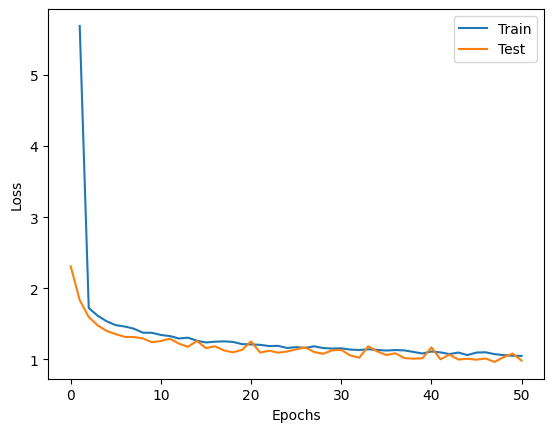

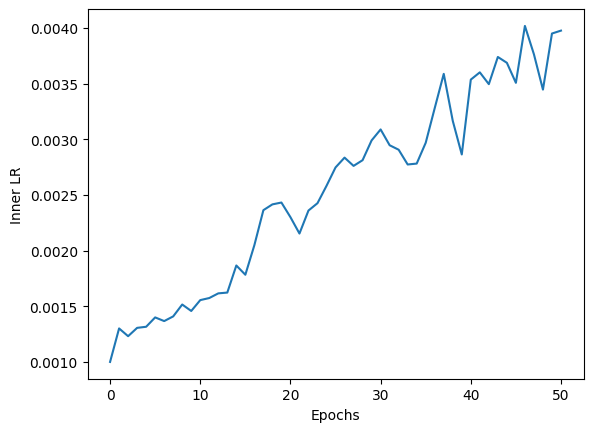

In [14]:
# define hyperparameters
use_train2generalize = 1
epochs = 50

inner_lr = torch.tensor([0.001], requires_grad=True, device="cuda") #0.001,
train_to_generalize_kwargs = {'reset_net': 1,
                              'inner_lr': inner_lr,
                              'use_l2l': 1,
                              'use_higher': 0,
                              'MLPT': 0.0,  # for real MLPT we need to include the first loss term too
                              }
batch_size = 128
lr = 0.001
weight_decay = 1e-4

# for MLPT we use half the batch size (divide a batch into two tasks)
if train_to_generalize_kwargs["MLPT"]:
    batch_size = batch_size // 2
# define train and test data loaders
from torch.utils.data import DataLoader, ConcatDataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size * 4, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size * 4, shuffle=False, num_workers=4)
gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=True)
# create loader that combine train and generalization data
train_gen_loader = DataLoader(ConcatDataset([train_data, gen_data]), batch_size=batch_size, shuffle=True, num_workers=4)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define model
#model = ConvNet(num_classes, n_channels, resolution).to(device)
model = CNet1(num_classes, n_channels, resolution).to(device)
# define optimizer
optimizer = torch.optim.AdamW(list(model.parameters()) + [inner_lr], lr=lr, weight_decay=weight_decay)
# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()


# train model
if use_train2generalize and not train_to_generalize_kwargs["MLPT"]:
    used_train_loader = train_loader
else:
    used_train_loader = train_gen_loader
if train_to_generalize_kwargs["MLPT"]:
    used_gen_loader = train_gen_loader
else:
    used_gen_loader = gen_loader

import numpy as np


# print model weight num
count = 0
for p in model.parameters():
    count += p.numel()
print("Number of parameters: ", count)
    
initial_test_loss = test(model, device, test_loader)

train_losses = [np.nan]
test_losses = [initial_test_loss]
inner_lrs = [inner_lr.item()]
for epoch in range(1, epochs + 1):
    save_graph = epoch == 1
    train_loss = train(model, device, train_loader, optimizer, scaler, epoch, use_train2generalize=use_train2generalize, 
                       gen_loader=gen_loader, train_to_generalize_kwargs=train_to_generalize_kwargs, save_graph=save_graph)
    test_loss = test(model, device, test_loader)
    # log
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    inner_lrs.append(inner_lr.item())
    

    
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

if use_train2generalize:
    plt.plot(inner_lrs, label="test")
    plt.xlabel("Epochs")
    plt.ylabel("Inner LR")
    plt.show()

In [13]:
# test model
test(model, device, test_loader)

Average loss: 0.9479, Accuracy: 6742/10000 (67.42%)


0.9478744390487671